/raid/hpc/hekai/miniconda3/envs/path_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.


<PIL.JpegImagePlugin.JpegImageFile image mode=CMYK size=492x357 at 0x7F39A42A7AD0>
what form a submucosal nodule composed of tumor cells embedded in dense fibrous tissue?
carcinoid tumors


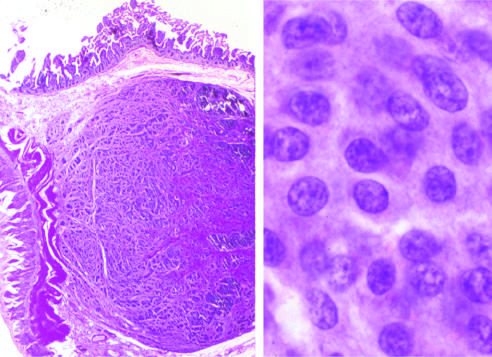

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6"

import torch
import sys
from datasets import load_dataset
from PIL import Image
import io

# 加载包含图片的数据集
# dataset = load_dataset('/raid/hpc/hekai/WorkShop/My_project/PathLLM_new/data/PathCap')  # 替换为实际的数据集名称
dataset = load_dataset('CNX-PathLLM/PVQAClean', split="train[:10]")  # 替换为实际的数据集名称

# 假设数据集中的一项包含了图片数据，例如 'image'
# 我们首先获取第一张图片的数据
image_data = dataset[0]['image']
question_data = dataset[0]['question']
answer_data = dataset[0]['answer']

# 图片数据可能是字节格式的，我们使用 BytesIO 来读取这些字节
# image = Image.open(io.BytesIO(image_data))
# image = Image.open(image_data)

print(image_data)
print(question_data)
print(answer_data)
# 显示图片
image_data.show()
image_data


In [2]:
from model.my_model import MyCustomModel
from transformers import TrainingArguments, AutoTokenizer, HfArgumentParser

def formatting_func(examples):
    question = examples["question"]
    answer = examples["answer"]
    text = f"<|Text|> {question}{tokenizer.eos_token} " + f"{answer}{tokenizer.eos_token}\n"
    examples["text"] = text
    # examples["image"] = examples["image"]
    return examples

llm_name = "mistralai/Mistral-7B-Instruct-v0.2"
clip_name = "conch"
load_in_8bit=False
load_in_4bit=False
trust_remote_code=False
token=True

from conch.open_clip_custom import create_model_from_pretrained
vision_encoder, image_processor = create_model_from_pretrained('conch_ViT-B-16', "load_weights/conch/pytorch_model.bin")

tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
new_tokens = ['<|Text|>',  '<|Image|>']  # 你要添加的特殊字符列表
num_added_toks = tokenizer.add_tokens(new_tokens)
new_tokens_ids = tokenizer.convert_tokens_to_ids(new_tokens)
print("new_tokens_ids: ", new_tokens_ids)

model = MyCustomModel(clip_name, 
                      load_in_8bit, 
                      load_in_4bit, 
                      llm_name, 
                      trust_remote_code, 
                      token, 
                      tokenizer,
                      new_tokens_ids[-1])
device = "cuda"
model.to(device)

new_tokens_ids:  [32000, 32001]
vision_encoder loading ...
llm loading ...


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


MyCustomModel(
  (vision_encoder): CoCa(
    (text): TextTransformer(
      (token_embedding): Embedding(32007, 768)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2): Identity()
          )
        )
      )
      (ln_final): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (visual): VisualModel(
      (trunk): Visio

In [3]:

# checkpoint_path = "output/checkpoint-800/result.pt"
# model.load_state_dict(torch.load(checkpoint_path, map_location=device),strict=False)

In [4]:
example = formatting_func(dataset[0])
print(example["text"])
input_dic = tokenizer(example["text"], return_tensors="pt")
map_image_data = image_processor(image_data)
input_dic["image"] = map_image_data

res = model.generate(input_ids = input_dic["input_ids"].to(device),
                    attention_mask = input_dic["attention_mask"].to(device),
                    labels = input_dic["input_ids"].to(device),
                    image = input_dic["image"].unsqueeze(0).to(device),
                )
print(res)

<|Text|> what form a submucosal nodule composed of tumor cells embedded in dense fibrous tissue?</s> carcinoid tumors</s>

['\nA submucosal nodule composed of tumor cells embedded in dense fibrous tissue is a characteristic feature of carcinoid tumors. Carcinoid tumors are neuroendocrine neoplasms that can occur in various locations throughout the gastrointestinal tract, but the most common sites are']
